In [3]:
!pip install -U matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

from osmox.helpers import area_grid

<AxesSubplot:>

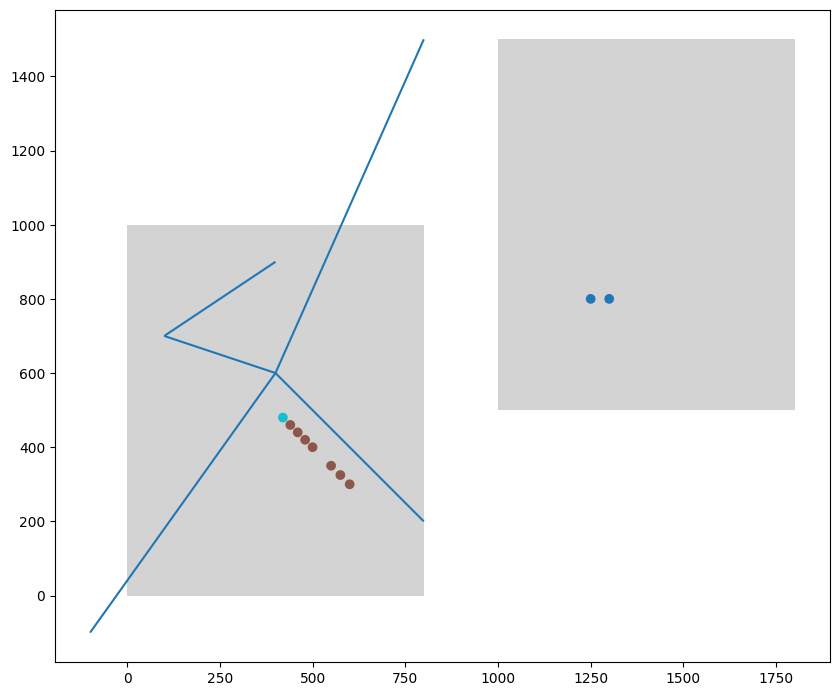

In [8]:

zones = gp.GeoDataFrame(
    {
        'id': [0, 1],
        'units': [50,100],
        'spacing': [50, 100],
        'geometry': [
            Polygon(((0,0),(800,0),(800,1000),(0,1000),(0,0))),
            Polygon(((1000,500),(1800,500),(1800,1500),(1000,1500),(1000,500))),
        ]
    }
)

nw = gp.GeoDataFrame(  # just oneway for now
    {
        'id': [0,1,2,3,4],
        'permlanes': [2,2,1,1,1],
        'geometry': [
            LineString(((-100,-100),(400,600))),
            LineString(((400,600), (800,1500))),
            LineString(((400,600), (800,200))),
            LineString(((400,600), (100,700))),
            LineString(((100,700),(400,900))),
        ]
    }
)

facilities = gp.GeoDataFrame(  # just oneway for now
    {
        'id': [0,1,2,3,4,5,6,7,8,9],
        'act': ["shop","home","home","home","home","home","home","home","education","education"],
        'geometry': [
            Point((420,480)),
            Point((440,460)),
            Point((460,440)),
            Point((480,420)),
            Point((500,400)),
            Point((550,350)),
            Point((575,325)),
            Point((600,300)),
            Point((1250,800)),
            Point((1300,800)),
        ]
    }
)

fig, ax = plt.subplots(figsize=(10,10))
zones.plot(ax=ax, color="lightgrey")
nw.plot(ax=ax)
facilities.plot(ax=ax, column="act")

In [9]:
def sample_new_facilities(zone, nw, existing):
    required = zone.units  # could use floor areas instead...
    existing_in_zone = clip_to_zone(existing, zone.geometry)
    required -= len(existing_in_zone)
    viable = gp.GeoDataFrame()
    print(f"commencing, {len(viable)}")
    
    if required > 0:
        print(f"nw sampler, required {required}")
        nw_viable = nw_viable_facilities(zone, nw, existing_in_zone)
        if required < len(nw_viable):
            nw_viable = nw_viable.sample(required)
        required -= len(nw_viable)
        viable = viable.append(nw_viable)
        print(f"adding from nw, {len(viable)} of {required}")
    
    if required > 0:
        print(f"grid sampler, required {required}")
        grid_viable = grid_viable_facilities(zone, existing_in_zone, viable)
        if required < len(grid_viable):
            grid_viable = grid_viable.sample(required)
        required -= len(grid_viable)
        viable = viable.append(grid_viable)
        print(f"adding from grid, {len(viable)} of {required}")
        
    if required > 0:
        # random sampler
        print("not implemented")
    
    if required > 0:
        # start to panic
        print("short")
    
    return viable
        
def nw_viable_facilities(zone, nw, existing):
    """
    todo needs to acconut for two-way roads!
    """
    viable_roads = filter_for_small_roads(nw)
    viable_roads = clip_to_zone(viable_roads, zone.geometry)
    viable_points = propose_locs(viable_roads, zone.spacing, zone.spacing)
    
    # following excludes viable points that are too close to existing
    viable_points = [p for p in viable_points if not any([True for x in existing.geometry if p.distance(x) <= zone.spacing])]
    # similar could be added to avoid clashing with roads etc
    
    return gp.GeoDataFrame(
        {
            'id': [f"{zone.id}_{i}nw" for i in range(len(viable_points))],
            'geometry': viable_points
        }
    )

def grid_viable_facilities(zone, existing, already_viable):
    viable_points = area_grid(zone.geometry, (zone.spacing, zone.spacing))
    viable_points = [Point(p) for p in viable_points]
    
    # following excludes viable points that are too close to existing
    viable_points = [p for p in viable_points if not any([True for x in existing.geometry if p.distance(x) <= zone.spacing])]
    viable_points = [p for p in viable_points if not any([True for x in already_viable.geometry if p.distance(x) <= zone.spacing])]

    # similar could be added to avoid clashing with roads etc
    return gp.GeoDataFrame(
        {
            'id': [f"{zone.id}_{i}grid" for i in range(len(viable_points))],
            'geometry': viable_points
        }
    )
    
def filter_for_small_roads(nw):
    return nw.loc[nw.permlanes==1]
    
def clip_to_zone(geoms, zone):
    return geoms.clip(zone)

def propose_locs(links, link_offset, spacing):
    offset_lines =  [l.parallel_offset(d) for l in links.geometry for d in [-link_offset, link_offset]]
    offset_points = [redistribute_vertices(l, spacing) for l in offset_lines]
    return [p for ps in offset_points for p in ps]
    
def redistribute_vertices(geom, distance):
    # https://gis.stackexchange.com/questions/367228/using-shapely-interpolate-to-evenly-re-sample-points-on-a-linestring-geodatafram
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return [geom.interpolate(float(n) / num_vert, normalized=True) for n in range(num_vert + 1)]
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

commencing, 0
nw sampler, required 42
adding from nw, 42 of 0
commencing, 0
nw sampler, required 98
adding from nw, 0 of 98
grid sampler, required 98
adding from grid, 94 of 4
not implemented
short


<AxesSubplot:>

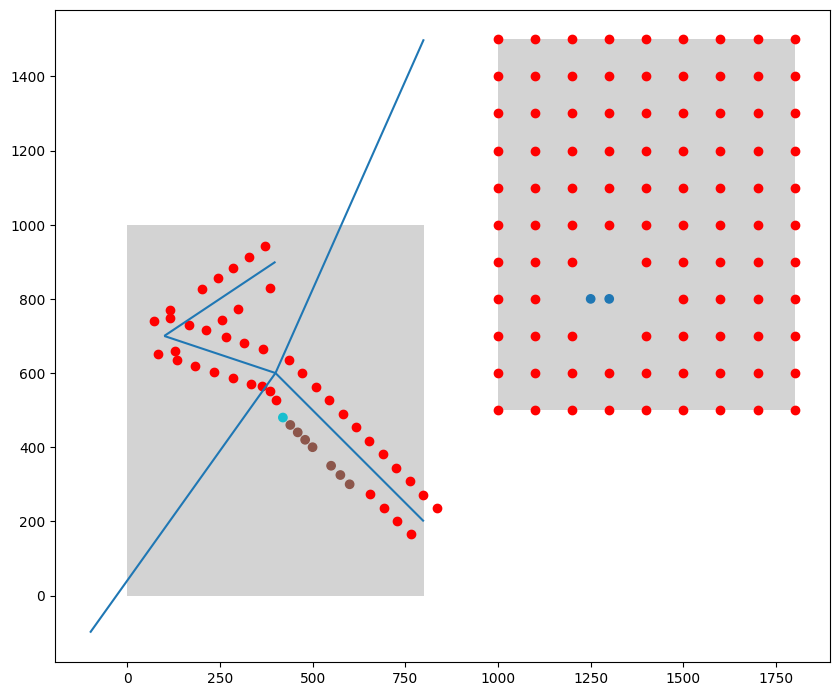

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
zones.plot(ax=ax, color="lightgrey")
nw.plot(ax=ax)
facilities.plot(ax=ax, column="act")
sample_new_facilities(zones.loc[0], nw, facilities).plot(ax=ax, color="red")
sample_new_facilities(zones.loc[1], nw, facilities).plot(ax=ax, color="red")